# Get performance evaluation for algorithms based on default parameters

This code is the exact same as the code in the gridsearch notebook, the only difference here is that we don't consider any range of hyperparameters, only the default ones.

# Setup

In [1]:
!pip install docker
!pip install timeeval --no-deps
!pip install durations numpyencoder distributed prts

    scikit-learn (>=0.24.*)
                  ~~~~~~~^
    scikit-learn (>=0.24.*)
                  ~~~~~~~^


## Import libraries

In [14]:
import os
import json
import subprocess
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from timeeval.utils.window import ReverseWindowing
import signal
import threading
from functools import wraps
import platform
import psutil
import gc
import traceback
from concurrent.futures import TimeoutError
from collections import defaultdict
from itertools import product
import random
import random
from scipy.sparse import csc_matrix, hstack
from timeeval.utils.window import ReverseWindowing
from timeeval import AlgorithmParameter

## Check if Docker is installed and running (if not install it from here: https://docs.docker.com/engine/install/ and open the app to allow Docker to run in the background)

In [3]:
def verify_docker():
    if not shutil.which("docker"):
        raise EnvironmentError("Docker is not installed or not in your PATH. Please install Docker.")

## Build Docker images

In [7]:
def pull_docker_images():
    images = [
        "ghcr.io/timeeval/cblof:0.3.0",
        "ghcr.io/timeeval/cof:0.3.0",
        "ghcr.io/timeeval/kmeans:0.3.0",
        "ghcr.io/timeeval/knn:0.3.0",
        "ghcr.io/timeeval/lof:0.3.0",
        "ghcr.io/timeeval/phasespace_svm:0.3.0",
        "ghcr.io/timeeval/subsequence_lof:0.3.0",
        "ghcr.io/timeeval/valmod:0.3.0",
        "ghcr.io/timeeval/grammarviz3:0.3.0",
        "ghcr.io/timeeval/dwt_mlead:0.3.0"
    ]

    # Build Docker images
    for image in images:
        try:
            subprocess.run(["docker", "pull", "--platform", "linux/amd64", image], check=True)
            print(f"Successfully pulled {image}.")
        except subprocess.CalledProcessError as e:
            print(f"Failed to pull {image}: {e}")

pull_docker_images()

0.3.0: Pulling from timeeval/cblof
Digest: sha256:4397c29daaac6a99d8cfc572fec055bf81a6bcad43cadc503c85443cd422f9be
Status: Image is up to date for ghcr.io/timeeval/cblof:0.3.0
ghcr.io/timeeval/cblof:0.3.0
Successfully pulled ghcr.io/timeeval/cblof:0.3.0.
0.3.0: Pulling from timeeval/cof
Digest: sha256:b6d9200d41641cf443bed91f3498b3b26f36b84d8fcb533f561c1279a7806352
Status: Image is up to date for ghcr.io/timeeval/cof:0.3.0
ghcr.io/timeeval/cof:0.3.0
Successfully pulled ghcr.io/timeeval/cof:0.3.0.
0.3.0: Pulling from timeeval/kmeans
Digest: sha256:acd5f5f6c8a644a02fa755e0fc274d323263f2f34e43e496fc174224b03e0ec8
Status: Image is up to date for ghcr.io/timeeval/kmeans:0.3.0
ghcr.io/timeeval/kmeans:0.3.0
Successfully pulled ghcr.io/timeeval/kmeans:0.3.0.
0.3.0: Pulling from timeeval/knn
Digest: sha256:a9bb4f68b291c0f91654c1275da9089e91ddff2203ecfbbc504af12504f461be
Status: Image is up to date for ghcr.io/timeeval/knn:0.3.0
ghcr.io/timeeval/knn:0.3.0
Successfully pulled ghcr.io/timeeval/knn

## Define paths

In [22]:
# Define paths to the algorithms
ALGORITHMS = {
    "CBLOF": "ghcr.io/timeeval/cblof:0.3.0",
    "COF": "ghcr.io/timeeval/cof:0.3.0",
    "kMeans": "ghcr.io/timeeval/kmeans:0.3.0",
    "KNN": "ghcr.io/timeeval/knn:0.3.0",
    "LOF": "ghcr.io/timeeval/lof:0.3.0",
    "PS-SVM": "ghcr.io/timeeval/phasespace_svm:0.3.0",
    "Sub-LOF": "ghcr.io/timeeval/subsequence_lof:0.3.0",
    "VALMOD": "ghcr.io/timeeval/valmod:0.3.0",
    "GrammarViz3": "ghcr.io/timeeval/grammarviz3:0.3.0",
    "DWT-MLEAD": "ghcr.io/timeeval/dwt_mlead:0.3.0"
}

## General function allowing you to run the algorithms

In [9]:
def run_algorithm(algorithm_name, data_path, execution_type="execute", custom_parameters=None):

    # Check if Docker image of algorithm was specified
    if algorithm_name not in ALGORITHMS:
        raise ValueError(f"Algorithm '{algorithm_name}' not found in ALGORITHMS dictionary.")
    
    # Check if the data file exists
    config = {
        "executionType": execution_type,
        "dataInput": "/" + data_path,
        "dataOutput": "/results/anomaly_scores.csv",
        "modelInput": "/results/model.pkl" if execution_type == "train" else "/results/trained_model.pkl",
        "modelOutput": "/results/trained_model.pkl" if execution_type == "train" else "/results/model.pkl",
        "customParameters": custom_parameters or {}
    }
    
    config_json = json.dumps(config)
    
    # Build Docker command
    cmd = [
        "docker", "run", "--rm",
        "-v", f"{os.getcwd()}/data:/data:ro",
        "-v", f"{os.getcwd()}/results:/results:rw",
        "--platform", "linux/amd64",
        ALGORITHMS[algorithm_name], "execute-algorithm", config_json
    ]
    
    # Execute Docker command
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    # Check for errors
    if result.returncode != 0:
        print(f"Error running {algorithm_name}: {result.stderr}")
        raise RuntimeError(f"Execution failed for {algorithm_name}")
    
    # Load and return anomaly scores
    scores_path = "./results/anomaly_scores.csv"
    scores = np.loadtxt(scores_path, delimiter=",")
    return scores

## This class + function handle timeout errors, we have introduced this due to some running for over 60s for a single dataset

In [10]:
class TimeoutError(Exception):
    pass

def timeout_handler(timeout):
    # Decorator that implements timeout for functions on both Unix and Windows
    def decorator(func):
        if platform.system() != 'Windows':
            # Unix-based systems can use signal
            def handler(signum, frame):
                raise TimeoutError(f"Function '{func.__name__}' timed out after {timeout} seconds")

            @wraps(func)
            def wrapper(*args, **kwargs):
                # Set signal handler
                old_handler = signal.signal(signal.SIGALRM, handler)
                signal.alarm(timeout)
                try:
                    result = func(*args, **kwargs)
                finally:
                    # Restore old handler and disable alarm
                    signal.alarm(0)
                    signal.signal(signal.SIGALRM, old_handler)
                return result
            
        else:
            # Windows implementation using threading
            @wraps(func)
            def wrapper(*args, **kwargs):
                result = []
                error = []
                
                def worker():
                    try:
                        result.append(func(*args, **kwargs))
                    except Exception as e:
                        error.append(e)
                
                thread = threading.Thread(target=worker)
                thread.daemon = True
                thread.start()
                thread.join(timeout)
                
                if thread.is_alive():
                    raise TimeoutError(f"Function '{func.__name__}' timed out after {timeout} seconds")
                if error:
                    raise error[0]
                return result[0]
                
        return wrapper
    return decorator

## Same idea as previous block, only for memory related issues

In [11]:
class MemoryError(Exception):
    pass

def check_memory_usage(threshold_percent=95):
    # Check if memory usage is above threshold
    memory_percent = psutil.Process(os.getpid()).memory_percent()
    if memory_percent > threshold_percent:
        raise MemoryError(f"Memory usage too high: {memory_percent:.1f}%")

def safe_load_data(file_path):
    # Safely load data with error handling
    try:
        return pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None

## Function that evaluates the algorithm based on the produced anomaly scores

In [12]:
def evaluate_algorithm(scores, data_path):
    # Load test data
    data_test = pd.read_csv(data_path)
    
    # Ensure 'is_anomaly' column exists in the data
    if 'is_anomaly' not in data_test.columns:
        raise ValueError(f"The test data at {data_path} must contain an 'is_anomaly' column.")

    # Extract the anomaly labels
    anomalies = data_test['is_anomaly']

    # Calculate AUC-ROC and AUC-PR
    auc_roc = roc_auc_score(anomalies, scores)
    precision, recall, _ = precision_recall_curve(anomalies, scores)
    auc_pr = auc(recall, precision)
    return auc_roc, auc_pr

## Some algorithms require post-processing. To find out the exact details of which ones need this, head to https://github.com/TimeEval/TimeEval-algorithms

In [15]:
# Post-processing for STAMP
def post_stamp(scores: np.ndarray, args: dict) -> np.ndarray:
    window_size = args.get("hyper_params", {}).get("anomaly_window_size", 30)
    if window_size < 4:
      print("WARN: window_size must be at least 4. Dynamically fixing it by setting window_size to 4")
      window_size = 4
    return ReverseWindowing(window_size=window_size).fit_transform(scores)

# Post-processing for STOMP
def post_stomp(scores: np.ndarray, args: dict) -> np.ndarray:
    window_size = args.get("hyper_params", {}).get("anomaly_window_size", 30)
    if window_size < 4:
      print("WARN: window_size must be at least 4. Dynamically fixing it by setting window_size to 4")
      window_size = 4
    return ReverseWindowing(window_size=window_size).fit_transform(scores)

# Post-processing for Sub-LOF
def post_sLOF(scores: np.ndarray, args: dict) -> np.ndarray:
    window_size = args.get("hyper_params", {}).get("window_size", 100)
    return ReverseWindowing(window_size=window_size).fit_transform(scores)

# Post-processing for VALMOD
def post_valmod(scores: np.ndarray, args: dict) -> np.ndarray:
    window_min = args.get("hyper_params", {}).get("min_anomaly_window_size", 30)
    window_min = max(window_min, 4)
    return ReverseWindowing(window_size=window_min).fit_transform(scores)

# Post-processing for GrammarViz3
def post_grammarviz(algorithm_parameter: AlgorithmParameter, args: dict) -> np.ndarray:
    if isinstance(algorithm_parameter, np.ndarray):
        results = pd.DataFrame(algorithm_parameter, columns=["index", "score", "length"])
        results = results.set_index("index")
    else:
        results = pd.read_csv(algorithm_parameter, header=None, index_col=0, names=["index", "score", "length"])
    anomalies = results[results["score"] > .0]

    # use scipy sparse matrix to save memory
    matrix = csc_matrix((len(results), 1), dtype=np.float64)
    counts = np.zeros(len(results))
    for i, row in anomalies.iterrows():
        idx = int(row.name)
        length = int(row["length"])
        tmp = np.zeros(len(results))
        tmp[idx:idx + length] = np.repeat([row["score"]], repeats=length)
        tmp = tmp.reshape(-1, 1)
        matrix = hstack([matrix, tmp])
        counts[idx:idx + length] += 1
    sums = matrix.sum(axis=1)
    counts = counts.reshape(-1, 1)
    scores = np.zeros_like(sums)
    np.divide(sums, counts, out=scores, where=counts != 0)
    # returns the completely flattened array (from `[[1.2], [2.3]]` to `[1.2, 2.3]`)
    return scores.A1  # type: ignore

## Can be ignored, is only relevant for the gridsearch notebook

In [16]:
def generate_parameter_combinations(param_grid, search_type='grid', n_iterations=None):
    if search_type == 'grid':
        return [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
    
    elif search_type == 'random':
        if n_iterations is None:
            # If n_iterations not specified, use the same number as grid search would produce
            n_iterations = np.prod([len(values) for values in param_grid.values()])
        
        combinations = []
        for _ in range(n_iterations):
            combination = {}
            for param_name, param_values in param_grid.items():
                combination[param_name] = random.choice(param_values)
            combinations.append(combination)
        
        return combinations
    
    else:
        raise ValueError("search_type must be either 'grid' or 'random'")

## Can be ignored, is only relevant for the gridsearch notebook

This function allows you to perform the default evaluation. As of now it is implemented to run it on the 100 worst perforiming datasets. If you wish to run it on a different collection of datasets, this can be modified in the code down below (see comments).

In [17]:
def parameter_search(algorithm_name, param_grid, search_type='grid', n_iterations=None):
    
    # Load datasets
    worst_performing_datasets = pd.read_csv("worst_performing_datasets.csv")
    
    # Track best results
    best_mean_auc_roc = -1
    best_results = {
        'params': None,
        'mean_auc_roc': -1,
        'dataset_scores': {},
        'metrics': {}
    }
    
    # Generate parameter combinations based on search type
    param_combinations = generate_parameter_combinations(
        param_grid, search_type, n_iterations)
    total_combinations = len(param_combinations)
    
    print(f"Starting {search_type} search for {algorithm_name}")
    print(f"Total parameter combinations to test: {total_combinations}")
    
    # Iterate through parameter combinations
    for param_idx, params in enumerate(param_combinations, 1):
        print(f"\nTesting combination {param_idx}/{total_combinations}")
        print(f"Parameters: {params}")
        
        current_results = {
            'dataset_scores': {},
            'metrics': defaultdict(dict)
        }
        
        # Add algorithm-specific defaults
        algorithm_defaults = {
            "STAMP": {"verbose": 0},
            "STOMP": {"verbose": 0},
            "VALMOD": {"verbose": 0}
        }
        
        if algorithm_name in algorithm_defaults:
            params.update(algorithm_defaults[algorithm_name])
        
        # Add random_state for reproducibility
        params["random_state"] = 42
        
        # Process each dataset
        for test_file in worst_performing_datasets['file_path']: # HERE YOU CAN CHANGE THE DATASETS TO RUN OVER!
            folder = os.path.basename(os.path.dirname(test_file))
            print(f"\nProcessing file: {test_file} in folder: {folder}")
            
            try:
                # Load test dataset
                data_test = safe_load_data(test_file)
                if data_test is None:
                    print(f"Skipping file {test_file} due to loading error")
                    continue
                
                # Run algorithm with current parameters
                if platform.system() != 'Windows':
                    # Unix implementation using signal
                    def timeout_handler(signum, frame):
                        raise TimeoutError("Operation timed out after 60 seconds")
                    
                    signal.signal(signal.SIGALRM, timeout_handler)
                    signal.alarm(60)
                    
                    try:
                        scores = run_algorithm(algorithm_name, test_file, custom_parameters=params)
                        check_memory_usage()
                        
                        # Apply algorithm-specific post-processing
                        if algorithm_name == "STAMP":
                            scores = post_stamp(scores, params)
                        elif algorithm_name == "STOMP":
                            scores = post_stomp(scores, params)
                        elif algorithm_name == "Sub-LOF":
                            scores = post_sLOF(scores, params)
                        elif algorithm_name == "VALMOD":
                            scores = post_valmod(scores, params)
                            
                    finally:
                        signal.alarm(0)
                
                else:
                    # Windows implementation using threading
                    result = []
                    error = []
                    
                    def worker():
                        try:
                            scores = run_algorithm(algorithm_name, test_file, custom_parameters=params)
                            check_memory_usage()
                            
                            # Apply algorithm-specific post-processing
                            if algorithm_name == "STAMP":
                                scores = post_stamp(scores, params)
                            elif algorithm_name == "STOMP":
                                scores = post_stomp(scores, params)
                            elif algorithm_name == "Sub-LOF":
                                scores = post_sLOF(scores, params)
                            elif algorithm_name == "VALMOD":
                                scores = post_valmod(scores, params)
                                
                            result.append(scores)
                        except Exception as e:
                            error.append(e)
                            traceback.print_exc()
                    
                    thread = threading.Thread(target=worker)
                    thread.daemon = True
                    thread.start()
                    thread.join(60)
                    
                    if thread.is_alive():
                        raise TimeoutError("Operation timed out after 60 seconds")
                    if error:
                        raise error[0]
                    scores = result[0]
                
                # Evaluate and store results
                auc_roc, auc_pr = evaluate_algorithm(scores, test_file)
                current_results['dataset_scores'][test_file] = scores
                current_results['metrics'][test_file] = {
                    'AUC-ROC': auc_roc,
                    'AUC-PR': auc_pr
                }
                
                print(f"Dataset: {folder} - AUC-ROC: {auc_roc:.3f}, AUC-PR: {auc_pr:.3f}")
                
            except Exception as e:
                print(f"Error processing {test_file}: {e}")
                traceback.print_exc()
                continue
        
        # Calculate mean AUC-ROC for current parameter set
        current_mean_auc_roc = np.mean([metrics['AUC-ROC'] 
                                      for metrics in current_results['metrics'].values()])
        
        print(f"\nMean AUC-ROC for parameters {params}: {current_mean_auc_roc:.3f}")
        
        # Update best results if current results are better
        if current_mean_auc_roc > best_mean_auc_roc:
            print(f"New best configuration found! Previous best: {best_mean_auc_roc:.3f}")
            best_mean_auc_roc = current_mean_auc_roc
            best_results = {
                'params': params,
                'mean_auc_roc': current_mean_auc_roc,
                'dataset_scores': current_results['dataset_scores'].copy(),
                'metrics': dict(current_results['metrics'])
            }
        
        # Clear memory
        gc.collect()
    
    # Save final results
    try:
        # Create results directory if it doesn't exist
        os.makedirs('./results', exist_ok=True)
        
        # Save best parameters and overall metrics
        results_df = pd.DataFrame({
            'Parameter': [k for k in best_results['params'].keys()],
            'Value': [v for v in best_results['params'].values()]
        })
        results_df.to_csv(
            f'./results/default_{algorithm_name.lower()}_parameters.csv', 
            index=False
        )
        
        # Save detailed metrics for each dataset
        detailed_metrics = []
        for dataset, metrics in best_results['metrics'].items():
            detailed_metrics.append({
                'Dataset': dataset,
                'AUC-ROC': metrics['AUC-ROC'],
                'AUC-PR': metrics['AUC-PR']
            })
        
        pd.DataFrame(detailed_metrics).to_csv(
            f'./results/default_{algorithm_name.lower()}_metrics.csv',
            index=False
        )
        
        # Save anomaly scores for each dataset
        np.savez(
            f'./results/default_{algorithm_name.lower()}_scores.npz',
            **best_results['dataset_scores']
        )
        
    except Exception as e:
        print(f"Error saving results: {e}")
        traceback.print_exc()
    
    return best_results

# CBLOF

In [29]:
param_grid = {}

cblof_results = parameter_search(algorithm_name="CBLOF", param_grid=param_grid)

Starting grid search for CBLOF
Total parameter combinations to test: 1

Testing combination 1/1
Parameters: {}

Processing file: data/NAB/occupancy_6005.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.478, AUC-PR: 0.104

Processing file: data/NASA-SMAP/F-1.test.csv in folder: NASA-SMAP
Dataset: NASA-SMAP - AUC-ROC: 0.463, AUC-PR: 0.013

Processing file: data/KDD-TSAD/161_UCR_Anomaly_WalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.413, AUC-PR: 0.027

Processing file: data/KDD-TSAD/053_UCR_Anomaly_DISTORTEDWalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.456, AUC-PR: 0.029

Processing file: data/NASA-MSL/P-15.test.csv in folder: NASA-MSL
Dataset: NASA-MSL - AUC-ROC: 0.387, AUC-PR: 0.006

Processing file: data/NAB/elb_request_count_8c0756.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.527, AUC-PR: 0.126

Processing file: data/GutenTAG/cbf-type-trend/test.csv in folder: cbf-type-trend
Dataset: cbf-type-trend - AUC-ROC: 0.5

# COF

In [31]:
param_grid = {}

cof_results = parameter_search(algorithm_name="COF", param_grid=param_grid)

Starting grid search for COF
Total parameter combinations to test: 1

Testing combination 1/1
Parameters: {}

Processing file: data/NAB/occupancy_6005.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.478, AUC-PR: 0.096

Processing file: data/NASA-SMAP/F-1.test.csv in folder: NASA-SMAP
Dataset: NASA-SMAP - AUC-ROC: 0.517, AUC-PR: 0.023

Processing file: data/KDD-TSAD/161_UCR_Anomaly_WalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.498, AUC-PR: 0.036

Processing file: data/KDD-TSAD/053_UCR_Anomaly_DISTORTEDWalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.521, AUC-PR: 0.037

Processing file: data/NASA-MSL/P-15.test.csv in folder: NASA-MSL
Dataset: NASA-MSL - AUC-ROC: 0.478, AUC-PR: 0.006

Processing file: data/NAB/elb_request_count_8c0756.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.533, AUC-PR: 0.115

Processing file: data/GutenTAG/cbf-type-trend/test.csv in folder: cbf-type-trend
Dataset: cbf-type-trend - AUC-ROC: 0.531

# kMeans

In [32]:
param_grid = {}

kmeans_results = parameter_search(algorithm_name="kMeans", param_grid=param_grid)

Starting grid search for kMeans
Total parameter combinations to test: 1

Testing combination 1/1
Parameters: {}

Processing file: data/NAB/occupancy_6005.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.381, AUC-PR: 0.090

Processing file: data/NASA-SMAP/F-1.test.csv in folder: NASA-SMAP
Dataset: NASA-SMAP - AUC-ROC: 0.406, AUC-PR: 0.022

Processing file: data/KDD-TSAD/161_UCR_Anomaly_WalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.172, AUC-PR: 0.019

Processing file: data/KDD-TSAD/053_UCR_Anomaly_DISTORTEDWalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.174, AUC-PR: 0.019

Processing file: data/NASA-MSL/P-15.test.csv in folder: NASA-MSL
Dataset: NASA-MSL - AUC-ROC: 0.999, AUC-PR: 0.963

Processing file: data/NAB/elb_request_count_8c0756.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.592, AUC-PR: 0.266

Processing file: data/GutenTAG/cbf-type-trend/test.csv in folder: cbf-type-trend
Dataset: cbf-type-trend - AUC-ROC: 0.

# KNN

In [33]:
param_grid = {}

knn_results = parameter_search(algorithm_name="KNN", param_grid=param_grid)

Starting grid search for KNN
Total parameter combinations to test: 1

Testing combination 1/1
Parameters: {}

Processing file: data/NAB/occupancy_6005.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.503, AUC-PR: 0.110

Processing file: data/NASA-SMAP/F-1.test.csv in folder: NASA-SMAP
Dataset: NASA-SMAP - AUC-ROC: 0.456, AUC-PR: 0.020

Processing file: data/KDD-TSAD/161_UCR_Anomaly_WalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.366, AUC-PR: 0.025

Processing file: data/KDD-TSAD/053_UCR_Anomaly_DISTORTEDWalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.392, AUC-PR: 0.026

Processing file: data/NASA-MSL/P-15.test.csv in folder: NASA-MSL
Dataset: NASA-MSL - AUC-ROC: 0.481, AUC-PR: 0.007

Processing file: data/NAB/elb_request_count_8c0756.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.520, AUC-PR: 0.142

Processing file: data/GutenTAG/cbf-type-trend/test.csv in folder: cbf-type-trend
Dataset: cbf-type-trend - AUC-ROC: 0.471

# LOF

In [34]:
param_grid = {}

lof_results = parameter_search(algorithm_name="LOF", param_grid=param_grid)

Starting grid search for LOF
Total parameter combinations to test: 1

Testing combination 1/1
Parameters: {}

Processing file: data/NAB/occupancy_6005.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.499, AUC-PR: 0.102

Processing file: data/NASA-SMAP/F-1.test.csv in folder: NASA-SMAP
Dataset: NASA-SMAP - AUC-ROC: 0.554, AUC-PR: 0.024

Processing file: data/KDD-TSAD/161_UCR_Anomaly_WalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.491, AUC-PR: 0.036

Processing file: data/KDD-TSAD/053_UCR_Anomaly_DISTORTEDWalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.499, AUC-PR: 0.034

Processing file: data/NASA-MSL/P-15.test.csv in folder: NASA-MSL
Dataset: NASA-MSL - AUC-ROC: 0.594, AUC-PR: 0.010

Processing file: data/NAB/elb_request_count_8c0756.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.502, AUC-PR: 0.107

Processing file: data/GutenTAG/cbf-type-trend/test.csv in folder: cbf-type-trend
Dataset: cbf-type-trend - AUC-ROC: 0.487

# PS-SVM

In [18]:
param_grid = {}

ps_svm_results = parameter_search(algorithm_name="PS-SVM", param_grid=param_grid)

Starting grid search for PS-SVM
Total parameter combinations to test: 1

Testing combination 1/1
Parameters: {}

Processing file: data/NAB/occupancy_6005.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.569, AUC-PR: 0.143

Processing file: data/NASA-SMAP/F-1.test.csv in folder: NASA-SMAP
Dataset: NASA-SMAP - AUC-ROC: 0.317, AUC-PR: 0.008

Processing file: data/KDD-TSAD/161_UCR_Anomaly_WalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.080, AUC-PR: 0.018

Processing file: data/KDD-TSAD/053_UCR_Anomaly_DISTORTEDWalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.080, AUC-PR: 0.018

Processing file: data/NASA-MSL/P-15.test.csv in folder: NASA-MSL
Dataset: NASA-MSL - AUC-ROC: 0.782, AUC-PR: 0.020

Processing file: data/NAB/elb_request_count_8c0756.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.678, AUC-PR: 0.451

Processing file: data/GutenTAG/cbf-type-trend/test.csv in folder: cbf-type-trend
Dataset: cbf-type-trend - AUC-ROC: 0.

# Sub-LOF

In [19]:
param_grid = {}

sub_lof_results = parameter_search(algorithm_name="Sub-LOF", param_grid=param_grid)

Starting grid search for Sub-LOF
Total parameter combinations to test: 1

Testing combination 1/1
Parameters: {}

Processing file: data/NAB/occupancy_6005.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.196, AUC-PR: 0.059

Processing file: data/NASA-SMAP/F-1.test.csv in folder: NASA-SMAP
Dataset: NASA-SMAP - AUC-ROC: 0.203, AUC-PR: 0.007

Processing file: data/KDD-TSAD/161_UCR_Anomaly_WalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.388, AUC-PR: 0.027

Processing file: data/KDD-TSAD/053_UCR_Anomaly_DISTORTEDWalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.384, AUC-PR: 0.026

Processing file: data/NASA-MSL/P-15.test.csv in folder: NASA-MSL
Dataset: NASA-MSL - AUC-ROC: 0.995, AUC-PR: 0.846

Processing file: data/NAB/elb_request_count_8c0756.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.778, AUC-PR: 0.502

Processing file: data/GutenTAG/cbf-type-trend/test.csv in folder: cbf-type-trend
Dataset: cbf-type-trend - AUC-ROC: 0

# VALMOD

In [20]:
param_grid = {}

valmod_results = parameter_search(algorithm_name="VALMOD", param_grid=param_grid)

Starting grid search for VALMOD
Total parameter combinations to test: 1

Testing combination 1/1
Parameters: {}

Processing file: data/NAB/occupancy_6005.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.393, AUC-PR: 0.076

Processing file: data/NASA-SMAP/F-1.test.csv in folder: NASA-SMAP
Dataset: NASA-SMAP - AUC-ROC: 0.390, AUC-PR: 0.010

Processing file: data/KDD-TSAD/161_UCR_Anomaly_WalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.208, AUC-PR: 0.020

Processing file: data/KDD-TSAD/053_UCR_Anomaly_DISTORTEDWalkingAceleration1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.261, AUC-PR: 0.021

Processing file: data/NASA-MSL/P-15.test.csv in folder: NASA-MSL
Dataset: NASA-MSL - AUC-ROC: 0.109, AUC-PR: 0.004

Processing file: data/NAB/elb_request_count_8c0756.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.500, AUC-PR: 0.100

Processing file: data/GutenTAG/cbf-type-trend/test.csv in folder: cbf-type-trend
Dataset: cbf-type-trend - AUC-ROC: 0.

Traceback (most recent call last):
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/4291609099.py", line 121, in parameter_search
    auc_roc, auc_pr = evaluate_algorithm(scores, test_file)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/2679600840.py", line 13, in evaluate_algorithm
    auc_roc = roc_auc_score(anomalies, scores)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py", line 619, in roc_auc_score
    y_score = check_array(y_score, ensure_2d=False)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions

Dataset: NAB - AUC-ROC: 0.047, AUC-PR: 0.055

Processing file: data/NAB/exchange-3_cpc_results.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.154, AUC-PR: 0.055

Processing file: data/NASA-MSL/F-7.test.csv in folder: NASA-MSL
Error processing data/NASA-MSL/F-7.test.csv: Input contains infinity or a value too large for dtype('float64').

Processing file: data/NAB/ec2_cpu_utilization_fe7f93.test.csv in folder: NAB


Traceback (most recent call last):
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/4291609099.py", line 121, in parameter_search
    auc_roc, auc_pr = evaluate_algorithm(scores, test_file)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/2679600840.py", line 13, in evaluate_algorithm
    auc_roc = roc_auc_score(anomalies, scores)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py", line 619, in roc_auc_score
    y_score = check_array(y_score, ensure_2d=False)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions

Dataset: NAB - AUC-ROC: 0.568, AUC-PR: 0.221

Processing file: data/NAB/speed_6005.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.360, AUC-PR: 0.080

Processing file: data/NAB/ec2_cpu_utilization_825cc2.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.367, AUC-PR: 0.072

Processing file: data/KDD-TSAD/019_UCR_Anomaly_DISTORTEDGP711MarkerLFM5z1.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.677, AUC-PR: 0.005

Processing file: data/NAB/rogue_agent_key_hold.test.csv in folder: NAB
Error running VALMOD: Welcome to Matrix Profile

Attaching package: ‘tsmp’

The following object is masked from ‘package:base’:

    write

Reading data from /data/NAB/rogue_agent_key_hold.test.csv
Error in if (motifs_per_size > 0) { : 
  missing value where TRUE/FALSE needed
Calls: valmod
Execution halted

Error processing data/NAB/rogue_agent_key_hold.test.csv: Execution failed for VALMOD

Processing file: data/GutenTAG/poly-type-mean/test.csv in folder: poly-type-mean


Traceback (most recent call last):
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/4291609099.py", line 68, in parameter_search
    scores = run_algorithm(algorithm_name, test_file, custom_parameters=params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/1694792707.py", line 26, in run_algorithm
    raise RuntimeError(f"Execution failed for {algorithm_name}")
RuntimeError: Execution failed for VALMOD


Dataset: poly-type-mean - AUC-ROC: 0.420, AUC-PR: 0.012

Processing file: data/NAB/exchange-4_cpm_results.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.335, AUC-PR: 0.295

Processing file: data/NAB/grok_asg_anomaly.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.467, AUC-PR: 0.126

Processing file: data/NAB/ec2_cpu_utilization_24ae8d.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.438, AUC-PR: 0.115

Processing file: data/NAB/ambient_temperature_system_failure.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.444, AUC-PR: 0.093

Processing file: data/GutenTAG/poly-type-trend/test.csv in folder: poly-type-trend
Dataset: poly-type-trend - AUC-ROC: 0.000, AUC-PR: 0.005

Processing file: data/NASA-SMAP/G-4.test.csv in folder: NASA-SMAP
Error running VALMOD: Welcome to Matrix Profile

Attaching package: ‘tsmp’

The following object is masked from ‘package:base’:

    write

Reading data from /data/NASA-SMAP/G-4.test.csv
Error in if (motifs_per_size > 0) { : 
  missing value where TR

Traceback (most recent call last):
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/4291609099.py", line 68, in parameter_search
    scores = run_algorithm(algorithm_name, test_file, custom_parameters=params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/1694792707.py", line 26, in run_algorithm
    raise RuntimeError(f"Execution failed for {algorithm_name}")
RuntimeError: Execution failed for VALMOD


Dataset: NAB - AUC-ROC: 0.682, AUC-PR: 0.277

Processing file: data/NAB/ec2_cpu_utilization_77c1ca.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.479, AUC-PR: 0.087

Processing file: data/NAB/ec2_network_in_5abac7.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.304, AUC-PR: 0.130

Processing file: data/GutenTAG/cbf-diff-count-1/test.csv in folder: cbf-diff-count-1
Dataset: cbf-diff-count-1 - AUC-ROC: 0.662, AUC-PR: 0.013

Processing file: data/NASA-MSL/T-8.test.csv in folder: NASA-MSL
Error running VALMOD: Welcome to Matrix Profile

Attaching package: ‘tsmp’

The following object is masked from ‘package:base’:

    write

Reading data from /data/NASA-MSL/T-8.test.csv
Error in if (motifs_per_size > 0) { : 
  missing value where TRUE/FALSE needed
Calls: valmod
Execution halted

Error processing data/NASA-MSL/T-8.test.csv: Execution failed for VALMOD

Processing file: data/GutenTAG/poly-diff-count-4/test.csv in folder: poly-diff-count-4


Traceback (most recent call last):
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/4291609099.py", line 68, in parameter_search
    scores = run_algorithm(algorithm_name, test_file, custom_parameters=params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/1694792707.py", line 26, in run_algorithm
    raise RuntimeError(f"Execution failed for {algorithm_name}")
RuntimeError: Execution failed for VALMOD


Dataset: poly-diff-count-4 - AUC-ROC: 0.437, AUC-PR: 0.043

Processing file: data/GutenTAG/poly-diff-count-5/test.csv in folder: poly-diff-count-5
Dataset: poly-diff-count-5 - AUC-ROC: 0.290, AUC-PR: 0.027

Processing file: data/NAB/ec2_network_in_257a54.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.368, AUC-PR: 0.072

Processing file: data/NASA-MSL/P-14.test.csv in folder: NASA-MSL
Dataset: NASA-MSL - AUC-ROC: 0.136, AUC-PR: 0.016

Processing file: data/GutenTAG/cbf-diff-count-4/test.csv in folder: cbf-diff-count-4
Dataset: cbf-diff-count-4 - AUC-ROC: 0.553, AUC-PR: 0.030

Processing file: data/NAB/exchange-4_cpc_results.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.409, AUC-PR: 0.289

Processing file: data/NormA/Discords_marotta_valve_tek_14.test.csv in folder: NormA
Dataset: NormA - AUC-ROC: 0.484, AUC-PR: 0.046

Processing file: data/NAB/iio_us-east-1_i-a2eb1cd9_NetworkIn.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.387, AUC-PR: 0.088

Processing file: data/NAB/TravelT

Traceback (most recent call last):
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/4291609099.py", line 121, in parameter_search
    auc_roc, auc_pr = evaluate_algorithm(scores, test_file)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/2679600840.py", line 13, in evaluate_algorithm
    auc_roc = roc_auc_score(anomalies, scores)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py", line 619, in roc_auc_score
    y_score = check_array(y_score, ensure_2d=False)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions

Dataset: NASA-MSL - AUC-ROC: 0.369, AUC-PR: 0.015

Processing file: data/NASA-MSL/P-10.test.csv in folder: NASA-MSL
Dataset: NASA-MSL - AUC-ROC: 0.092, AUC-PR: 0.012

Processing file: data/NASA-MSL/T-4.test.csv in folder: NASA-MSL
Error running VALMOD: Welcome to Matrix Profile

Attaching package: ‘tsmp’

The following object is masked from ‘package:base’:

    write

Reading data from /data/NASA-MSL/T-4.test.csv
Error in if (motifs_per_size > 0) { : 
  missing value where TRUE/FALSE needed
Calls: valmod
Execution halted

Error processing data/NASA-MSL/T-4.test.csv: Execution failed for VALMOD

Processing file: data/GutenTAG/cbf-same-count-5/test.csv in folder: cbf-same-count-5


Traceback (most recent call last):
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/4291609099.py", line 68, in parameter_search
    scores = run_algorithm(algorithm_name, test_file, custom_parameters=params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/1694792707.py", line 26, in run_algorithm
    raise RuntimeError(f"Execution failed for {algorithm_name}")
RuntimeError: Execution failed for VALMOD


Dataset: cbf-same-count-5 - AUC-ROC: 0.620, AUC-PR: 0.059

Processing file: data/GutenTAG/poly-combined-diff-3/test.csv in folder: poly-combined-diff-3
Dataset: poly-combined-diff-3 - AUC-ROC: 0.390, AUC-PR: 0.008

Processing file: data/GutenTAG/cbf-same-count-1/test.csv in folder: cbf-same-count-1
Dataset: cbf-same-count-1 - AUC-ROC: 0.483, AUC-PR: 0.009

Processing file: data/GutenTAG/cbf-position-end/test.csv in folder: cbf-position-end
Dataset: cbf-position-end - AUC-ROC: 0.593, AUC-PR: 0.013

Processing file: data/NAB/ec2_cpu_utilization_5f5533.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.599, AUC-PR: 0.135

Processing file: data/GutenTAG/cbf-same-count-2/test.csv in folder: cbf-same-count-2
Dataset: cbf-same-count-2 - AUC-ROC: 0.586, AUC-PR: 0.022

Processing file: data/NAB/TravelTime_451.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.589, AUC-PR: 0.118

Processing file: data/NAB/ec2_cpu_utilization_53ea38.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.584, AUC-PR: 0.1

Traceback (most recent call last):
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/4291609099.py", line 68, in parameter_search
    scores = run_algorithm(algorithm_name, test_file, custom_parameters=params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/1694792707.py", line 26, in run_algorithm
    raise RuntimeError(f"Execution failed for {algorithm_name}")
RuntimeError: Execution failed for VALMOD


Dataset: NormA - AUC-ROC: 0.398, AUC-PR: 0.019

Processing file: data/GutenTAG/cbf-combined-diff-1/test.csv in folder: cbf-combined-diff-1
Dataset: cbf-combined-diff-1 - AUC-ROC: 0.549, AUC-PR: 0.101

Processing file: data/NAB/art_daily_jumpsdown.test.csv in folder: NAB
Dataset: NAB - AUC-ROC: 0.539, AUC-PR: 0.110

Processing file: data/GutenTAG/poly-diff-count-3/test.csv in folder: poly-diff-count-3
Dataset: poly-diff-count-3 - AUC-ROC: 0.429, AUC-PR: 0.016

Processing file: data/KDD-TSAD/069_UCR_Anomaly_DISTORTEDinsectEPG5.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.997, AUC-PR: 0.015

Processing file: data/KDD-TSAD/107_UCR_Anomaly_NOISEinsectEPG3.test.csv in folder: KDD-TSAD
Dataset: KDD-TSAD - AUC-ROC: 0.749, AUC-PR: 0.012

Processing file: data/GutenTAG/cbf-same-count-10/test.csv in folder: cbf-same-count-10
Dataset: cbf-same-count-10 - AUC-ROC: 0.634, AUC-PR: 0.112

Processing file: data/KDD-TSAD/097_UCR_Anomaly_NOISEGP711MarkerLFM5z3.test.csv in folder: KDD-TSAD


Traceback (most recent call last):
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/4291609099.py", line 68, in parameter_search
    scores = run_algorithm(algorithm_name, test_file, custom_parameters=params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/1694792707.py", line 26, in run_algorithm
    raise RuntimeError(f"Execution failed for {algorithm_name}")
RuntimeError: Execution failed for VALMOD


Dataset: cbf-type-amplitude - AUC-ROC: 0.687, AUC-PR: 0.014

Processing file: data/GutenTAG/sinus-same-count-10/test.csv in folder: sinus-same-count-10
Dataset: sinus-same-count-10 - AUC-ROC: 0.659, AUC-PR: 0.126

Processing file: data/NAB/art_increase_spike_density.test.csv in folder: NAB
Error running VALMOD: Welcome to Matrix Profile

Attaching package: ‘tsmp’

The following object is masked from ‘package:base’:

    write

Reading data from /data/NAB/art_increase_spike_density.test.csv
Error in if (motifs_per_size > 0) { : 
  missing value where TRUE/FALSE needed
Calls: valmod
Execution halted

Error processing data/NAB/art_increase_spike_density.test.csv: Execution failed for VALMOD

Processing file: data/KDD-TSAD/159_UCR_Anomaly_TkeepSecondMARS.test.csv in folder: KDD-TSAD


Traceback (most recent call last):
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/4291609099.py", line 68, in parameter_search
    scores = run_algorithm(algorithm_name, test_file, custom_parameters=params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/1694792707.py", line 26, in run_algorithm
    raise RuntimeError(f"Execution failed for {algorithm_name}")
RuntimeError: Execution failed for VALMOD


Dataset: KDD-TSAD - AUC-ROC: 0.703, AUC-PR: 0.001

Processing file: data/GutenTAG/ecg-noise-50%/test.csv in folder: ecg-noise-50%
Dataset: ecg-noise-50% - AUC-ROC: 0.768, AUC-PR: 0.044

Processing file: data/generated_data/dataset_0.test.csv in folder: generated_data
Error running VALMOD: Welcome to Matrix Profile

Attaching package: ‘tsmp’

The following object is masked from ‘package:base’:

    write

Reading data from /data/generated_data/dataset_0.test.csv
Error in if (motifs_per_size > 0) { : 
  missing value where TRUE/FALSE needed
Calls: valmod
Execution halted

Error processing data/generated_data/dataset_0.test.csv: Execution failed for VALMOD

Processing file: data/generated_data/dataset_1.test.csv in folder: generated_data


Traceback (most recent call last):
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/4291609099.py", line 68, in parameter_search
    scores = run_algorithm(algorithm_name, test_file, custom_parameters=params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/1694792707.py", line 26, in run_algorithm
    raise RuntimeError(f"Execution failed for {algorithm_name}")
RuntimeError: Execution failed for VALMOD


Dataset: generated_data - AUC-ROC: 0.681, AUC-PR: 0.118

Processing file: data/generated_data/dataset_2.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.416, AUC-PR: 0.026

Processing file: data/generated_data/dataset_3.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.760, AUC-PR: 0.014

Processing file: data/generated_data/dataset_4.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.833, AUC-PR: 0.022

Processing file: data/generated_data/dataset_5.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.881, AUC-PR: 0.177

Processing file: data/generated_data/dataset_6.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.583, AUC-PR: 0.065

Processing file: data/generated_data/dataset_7.test.csv in folder: generated_data
Error running VALMOD: Welcome to Matrix Profile

Attaching package: ‘tsmp’

The following object is masked from ‘package:base’:

    write

Reading data from /data/ge

Traceback (most recent call last):
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/4291609099.py", line 68, in parameter_search
    scores = run_algorithm(algorithm_name, test_file, custom_parameters=params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/1694792707.py", line 26, in run_algorithm
    raise RuntimeError(f"Execution failed for {algorithm_name}")
RuntimeError: Execution failed for VALMOD


Dataset: generated_data - AUC-ROC: 0.230, AUC-PR: 0.009

Processing file: data/generated_data/dataset_9.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.745, AUC-PR: 0.001

Processing file: data/generated_data/dataset_10.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.924, AUC-PR: 0.020

Processing file: data/generated_data/dataset_11.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.781, AUC-PR: 0.030

Processing file: data/generated_data/dataset_12.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.017, AUC-PR: 0.003

Processing file: data/generated_data/dataset_13.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.853, AUC-PR: 0.080

Processing file: data/generated_data/dataset_14.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.979, AUC-PR: 0.032

Processing file: data/generated_data/dataset_15.test.csv in folder: generated_data
Error running VALMOD:

Traceback (most recent call last):
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/4291609099.py", line 68, in parameter_search
    scores = run_algorithm(algorithm_name, test_file, custom_parameters=params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_4531/1694792707.py", line 26, in run_algorithm
    raise RuntimeError(f"Execution failed for {algorithm_name}")
RuntimeError: Execution failed for VALMOD


Dataset: generated_data - AUC-ROC: 0.584, AUC-PR: 0.052

Processing file: data/generated_data/dataset_17.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.333, AUC-PR: 0.005

Processing file: data/generated_data/dataset_18.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.509, AUC-PR: 0.031

Processing file: data/generated_data/dataset_19.test.csv in folder: generated_data
Dataset: generated_data - AUC-ROC: 0.652, AUC-PR: 0.030

Mean AUC-ROC for parameters {'verbose': 0, 'random_state': 42}: 0.512
New best configuration found! Previous best: -1.000


# GrammarViz3

In [ ]:
param_grid = {}

grammarviz3_results = parameter_search(algorithm_name="GrammarViz3", param_grid=param_grid)

# DWT-MLEAD

In [ ]:
param_grid = {}

dwt_mlead_results = parameter_search(algorithm_name="DWT-MLEAD", param_grid=param_grid)

# Plot results

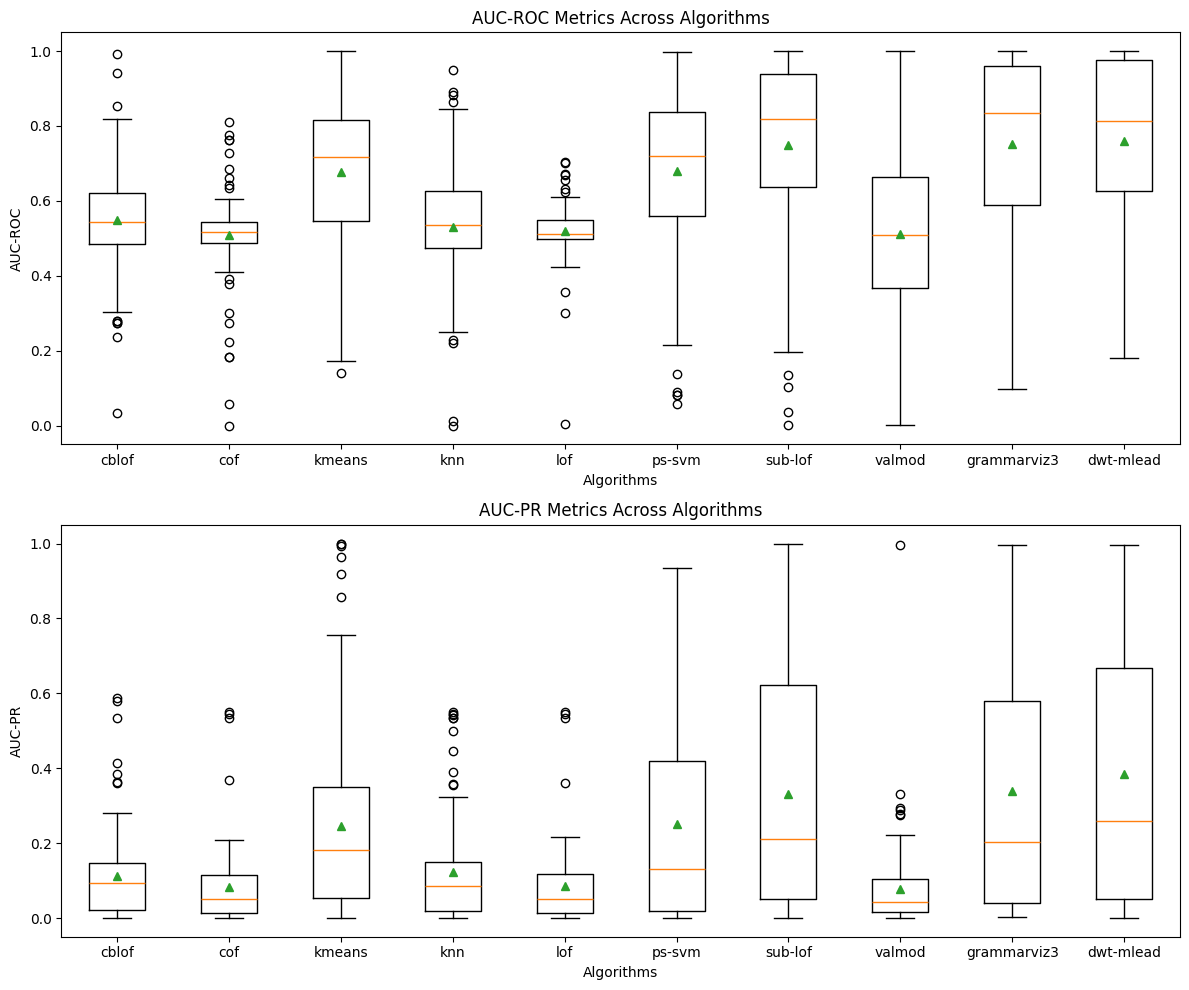

In [24]:
# Define file path templates
grid_template = "./results/default_{}_metrics.csv"
random_template = "./results/default_{}_metrics.csv"

# Initialize dictionaries to store metrics for each algorithm
auc_roc_data = {}
auc_pr_data = {}

# Read data for each algorithm
for algo in ALGORITHMS:
    algo = algo.lower()
    grid_path = grid_template.format(algo)
    random_path = random_template.format(algo)
    if os.path.exists(grid_path):
        df = pd.read_csv(grid_path)
        auc_roc_data[algo] = df["AUC-ROC"].values
        auc_pr_data[algo] = df["AUC-PR"].values
    elif os.path.exists(random_path):
        df = pd.read_csv(random_path)
        auc_roc_data[algo] = df["AUC-ROC"].values
        auc_pr_data[algo] = df["AUC-PR"].values
    else:
        print(f"No file found for algorithm {algo}.")

# Filter algorithms with valid data
valid_algorithms = []
auc_roc_values = []
auc_pr_values = []

for algo in ALGORITHMS:
    algo = algo.lower()
    if algo in auc_roc_data and len(auc_roc_data[algo]) > 0:
        valid_algorithms.append(algo)
        auc_roc_values.append(auc_roc_data[algo])
        auc_pr_values.append(auc_pr_data[algo])

# Create a figure for the plots
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot AUC-ROC values
ax[0].boxplot(auc_roc_values, tick_labels=valid_algorithms, showmeans=True)
ax[0].set_title("AUC-ROC Metrics Across Algorithms")
ax[0].set_ylabel("AUC-ROC")
ax[0].set_xlabel("Algorithms")

# Plot AUC-PR values
ax[1].boxplot(auc_pr_values, tick_labels=valid_algorithms, showmeans=True)
ax[1].set_title("AUC-PR Metrics Across Algorithms")
ax[1].set_ylabel("AUC-PR")
ax[1].set_xlabel("Algorithms")

plt.tight_layout()
plt.show()